In [ ]:
def check_connections(matrix):
    connections = {}
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] == 1:
                connections.setdefault(i, []).append(j)

    return connections


matrix = [[0, 1, 1, 0],
          [1, 0, 1, 0],
          [1, 1, 0, 1],
          [0, 0, 1, 0]]

print(check_connections(matrix))

{0: [1, 2], 1: [0, 2], 2: [0, 1, 3], 3: [2]}


Tasks completion: 0.35294117647058826
Deadline: 1.0


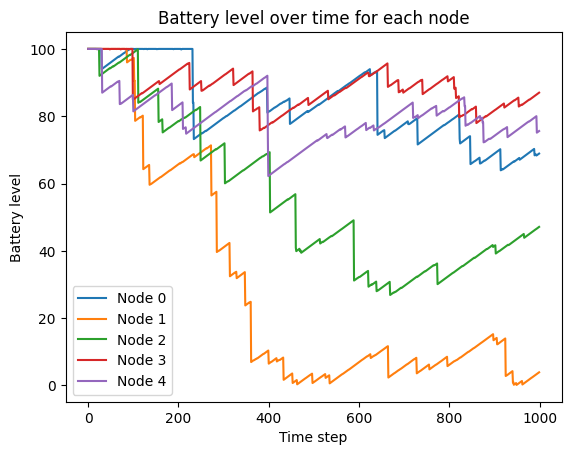

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

Task = namedtuple('Task', ['deadline', 'energy_cost', 'initial_energy_cost'])

class NodeEnvironment:
    def __init__(self, topology, initial_battery_levels, energy_source_rate=0.1, min_battery_percent=0.2, max_steps=1000, send_energy_cost_factor=0.01):
        self.topology = topology
        self.num_nodes = len(topology)
        self.battery_levels = initial_battery_levels.copy()
        self.initial_battery_levels = initial_battery_levels.copy()
        self.energy_source_rate = energy_source_rate
        self.min_battery_percent = min_battery_percent
        self.battery_level_step = 10
        self.time_step = 0
        self.current_node = 0
        self.tasks_queue = [[] for _ in range(self.num_nodes)]
        self.tasks_completion = []
        self.max_steps = max_steps
        self.total_task_energy = 0
        self.send_energy_cost_factor = send_energy_cost_factor

    def get_state(self):
        state = [self.current_node]
        if self.tasks_queue[self.current_node]:  # If there's a task in the queue of the current node
            task = self.tasks_queue[self.current_node][0]
            state.append(task.energy_cost)  # Include the energy cost of the task in the state
        else:
            state.append(0)
        state.extend(self.battery_levels)  # Include the battery levels of all nodes in the state
        return state

    def get_possible_actions(self):
        possible_actions = list(range(self.num_nodes))  # The possible actions are to process the task locally or send it to any other node
        return possible_actions

    def step(self, action):
        reward = 0
        done = False
        self.time_step += 1
        self.recharge_nodes()
        if action == self.current_node:  # If the action is to process the task on the current node
            task_done = self.perform_task(self.current_node)
            if task_done:
                reward = 1  # Reward for task completion
        else:  # If the action is to send the task to another node
            task_sent = self.send_task(self.current_node, action)
            # No immediate reward for sending a task
        self.current_node = (self.current_node + 1) % self.num_nodes  # Move to the next node
        if self.time_step >= self.max_steps or all(all(tasks_queue) for tasks_queue in self.tasks_queue):
            done = True
        return self.get_state(), reward, done

    def perform_task(self, node):
        if not self.tasks_queue[node]:
            return False
        task = self.tasks_queue[node][0]
        min_battery_level = self.min_battery_percent * self.battery_levels[node]
        max_energy_use = max(0, self.battery_levels[node] - min_battery_level)
        energy_used = min(task.energy_cost, max_energy_use)
        remaining_energy_cost = task.energy_cost - energy_used
        if remaining_energy_cost == 0:
            self.tasks_queue[node].pop(0)
            if self.time_step <= task.deadline:  # Check if the task is completed within its deadline
                self.tasks_completion.append((task.initial_energy_cost, self.time_step - task.deadline))
                #
        else:
            new_task = Task(task.deadline, remaining_energy_cost, task.initial_energy_cost)  # Create a new task with the remaining energy cost
            self.tasks_queue[node][0] = new_task  # Replace the existing task with the new one
        self.battery_levels[node] = max(0, self.battery_levels[node] - energy_used)
        return remaining_energy_cost == 0

    def send_task(self, from_node, to_node):
        if not self.tasks_queue[from_node] or self.battery_levels[from_node] <= self.min_battery_percent * self.battery_levels[from_node]:
            return False
        task = self.tasks_queue[from_node][0]
        energy_required = min(task.energy_cost, self.battery_levels[from_node])
        send_energy_cost = energy_required * self.send_energy_cost_factor
        if send_energy_cost > self.battery_levels[from_node]:
            return False
        remaining_energy_cost = task.energy_cost - energy_required
        if remaining_energy_cost == 0:
            self.tasks_queue[from_node].pop(0)
        else:
            self.tasks_queue[from_node][0] = Task(task.deadline, remaining_energy_cost, task.initial_energy_cost)
        new_task = Task(task.deadline, energy_required, task.initial_energy_cost)
        self.assign_task(to_node, new_task)
        self.battery_levels[from_node] = max(0, self.battery_levels[from_node] - send_energy_cost)
        return True
    def idle(self):
        for node in range(len(self.battery_levels)):
            if self.battery_levels[node] > self.min_battery_percent * self.battery_levels[node]:
                self.battery_levels[node] = max(0, self.battery_levels[node] - self.idle_energy_cost)

    def recharge_nodes(self):
        for i in range(len(self.battery_levels)):
            recharge_amount = min(self.energy_source_rate, self.initial_battery_levels[i] - self.battery_levels[i])
            self.battery_levels[i] += recharge_amount

    def assign_task(self, node, task):
        self.tasks_queue[node].append(task)
        self.total_task_energy += task.initial_energy_cost

class QLearningAgent:
    def __init__(self, num_nodes, learning_rate=0.5, discount_factor=0.95, initial_epsilon=1.0, epsilon_decay_rate=0.995, min_epsilon=0.01):
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        self.num_nodes = num_nodes
        self.Q = {}

    def choose_action(self, state, possible_actions):
        current_node, battery_level, task_energy_cost, task_deadline, *connected_nodes_battery_levels = state
        state = tuple(state)
        if np.random.uniform(0, 1) < self.epsilon:  # epsilon-greedy exploration
            return np.random.choice(possible_actions)
        else:
            Q_values = [self.Q.get((state, action), 0) for action in possible_actions]
            max_Q_value = max(Q_values)
            max_actions = [action for action, Q_value in zip(possible_actions, Q_values) if Q_value == max_Q_value]
            return np.random.choice(max_actions)
    def update(self, state, action, reward, next_state):
        state = tuple(state)
        next_state = tuple(next_state)
        current_Q_value = self.Q.get((state, action), 0)
        next_Q_values = [self.Q.get((next_state, next_action), 0) for next_action in range(self.num_nodes)]
        future_reward = max(next_Q_values) if not done else 0
        self.Q[(state, action)] = current_Q_value + self.alpha * (reward + self.gamma * future_reward - current_Q_value)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_rate)  # Apply epsilon decay

topology = [[0, 1, 0, 0, 0],
 [1, 0, 1, 0, 1],
 [0, 1, 0, 1, 1],
 [0, 0, 1, 0, 1],
 [0, 1, 1, 1, 0]]
battery_levels = [100, 100, 100, 100, 100]

env = NodeEnvironment(topology, battery_levels)
agent = QLearningAgent(len(topology))

battery_distribution = []

for episode in range(1000):
    env.current_node = np.random.choice(len(topology))
    for time_step in range(1000):
        if np.random.uniform(0, 1) < 0.08:
            energy_cost = np.random.randint(1, 20)
            task = Task(deadline= np.random.randint(1, 500), energy_cost=energy_cost, initial_energy_cost=energy_cost)
            env.assign_task(env.current_node, task)
        state = env.get_state()
        possible_actions = env.get_possible_actions()
        action = agent.choose_action(state, possible_actions)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, next_state)
        battery_distribution.append(list(env.battery_levels))
        if done:
            break

completed_tasks = len(env.tasks_completion)
total_tasks = sum([len(node_tasks) for node_tasks in env.tasks_queue]) + completed_tasks

completed_ratio = completed_tasks / total_tasks if total_tasks else 0
deadline_adherence_ratio = sum(d <= 0 for _, d in env.tasks_completion) / len(env.tasks_completion) if env.tasks_completion else 0

print(f"Tasks completion: {completed_ratio}")
print(f"Deadline: {deadline_adherence_ratio}")

battery_distribution = np.array(battery_distribution)
for i in range(len(topology)):
    plt.plot(battery_distribution[:, i], label=f"Node {i}")
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Battery level")
plt.title("Battery level over time for each node")
plt.show()


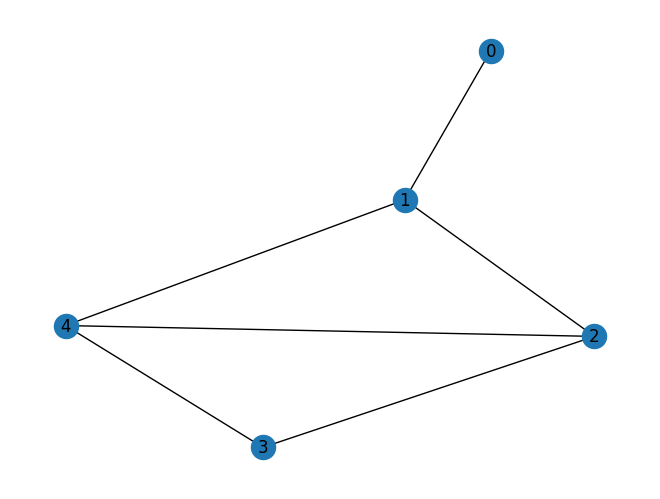

In [ ]:
plot_topology(topology)

In [ ]:
pip install networkx matplotlib

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_topology(topology):
    G = nx.Graph()

    for i in range(len(topology)):
        for j in range(i, len(topology[i])):
            if topology[i][j] == 1:
                G.add_edge(i, j)

    nx.draw(G, with_labels=True)
    plt.show()
